# Representation learning : Autoencoders



Autoencoders are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. 

Specifically, we'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input. 

If the input features were each independent of one another, this compression and subsequent reconstruction would be a very difficult task. However, if some sort of structure exists in the data (ie. correlations between input features), this structure can be learned and consequently leveraged when forcing the input through the network's bottleneck.

We can take an unlabeled dataset and frame it as a supervised learning problem tasked with outputting $\hat(X)$, a reconstruction of the original input $X$. This network can be trained by minimizing the reconstruction error, $L(X,\hat(X)$, which measures the differences between our original input and the consequent reconstruction. The bottleneck is a key attribute of our network design; without the presence of an information bottleneck, our network could easily learn to simply memorize the input values by passing these values along through the network.


A bottleneck constrains the amount of information that can traverse the full network, forcing a learned compression of the input data.

In fact, if we were to construct a linear network (ie. without the use of nonlinear activation functions at each layer) we would observe a similar dimensionality reduction as observed in PCA. 

The ideal autoencoder model balances the following:

- Sensitive to the inputs enough to accurately build a reconstruction.
- Insensitive enough to the inputs that the model doesn't simply memorize or overfit the training data.


The simplest architecture for constructing an autoencoder is to constrain the number of nodes present in the hidden layer(s) of the network, limiting the amount of information that can flow through the network. By penalizing the network according to the reconstruction error, our model can learn the most important attributes of the input data and how to best reconstruct the original input from an "encoded" state. Ideally, this encoding will learn and describe latent attributes of the input data.


Because neural networks are capable of learning nonlinear relationships, this can be thought of as a more powerful nonlinear generalization of PCA. Whereas PCA attempts to discover a lower dimensional hyperplane which describes the original data, autoencoders are capable of learning nonlinear relations.

In [1]:
import torch
import torch.nn as nn
 
import torchvision.datasets as datasets
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
X = X/X.max()
X = X.astype(np.float32)

In [5]:
class AutoEncoder( torch.nn.Module ):
    
    def __init__(self, input_size=784, hidden_size = 50, output_size=10):
        
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
                torch.nn.Linear( input_size, hidden_size),
                torch.nn.Sigmoid()
            )
        
        self.decoder = nn.Sequential(
                torch.nn.Dropout(0.5),
                torch.nn.Linear( hidden_size, input_size)
            )
    
    def forward(self, x):
        
        out = self.encoder(x)
        out = self.decoder(out)
            
        return out
        
        

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=42)

In [7]:
x_in = torch.rand( 784 ).unsqueeze(0)
net = AutoEncoder()



In [8]:
net = AutoEncoder(hidden_size=200)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)

In [9]:
BATCH_SIZE = 16

In [10]:
NUM_EPOCHS = 10
epoch_loss = []
accs = []
for epoch in range(NUM_EPOCHS):
    losses = []
    
    net.train()
    for i in range(0, X_train.shape[0], BATCH_SIZE):

        optimizer.zero_grad()
        x_in = torch.from_numpy( X[i:i+BATCH_SIZE] )

        ret = net(x_in)
        loss = loss_fn(ret, x_in)

        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    epoch_loss.append(np.mean(losses))
    
    
    if epoch % 5 == 0 :
        print( f"epoch {epoch}, train loss={np.mean(epoch_loss):.3}")
    

/home/kostas/.local/share/virtualenvs/ml_lectures-_epG6xXj/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


epoch 0, train loss=0.102
epoch 5, train loss=0.0774


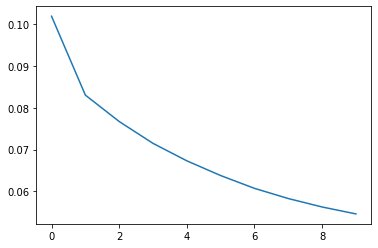

In [11]:
plt.plot( range(NUM_EPOCHS), epoch_loss)

In [12]:
representation = net.encoder(x_in)

In [13]:
representation.shape

torch.Size([16, 200])

In [14]:
## Denoising

In [41]:
noise_factor = 0.5
x_noisy = X_train.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape).astype(np.float32)
x_noisy = np.clip(x_noisy, 0., 1.)

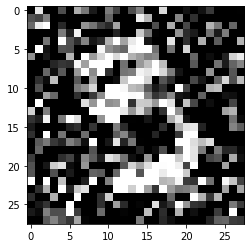

In [42]:
plt.imshow( x_noisy[0].reshape( 28, 28), cmap="gray") 

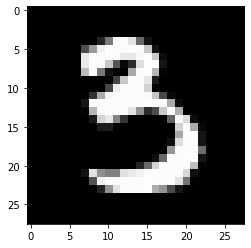

In [43]:
plt.imshow( X_train[0].reshape( 28, 28), cmap="gray") 

In [69]:
denoiser = AutoEncoder(hidden_size=100)

In [70]:
x_noisy.dtype

dtype('float32')

In [71]:
dn_loss = torch.nn.MSELoss()
dn_optimiser = torch.optim.Adam( denoiser.parameters())

In [72]:
NUM_EPOCHS = 15
epoch_loss = []
accs = []
for epoch in range(NUM_EPOCHS):
    losses = []
    
    denoiser.train()
    for i in range(0, X_train.shape[0], BATCH_SIZE):

        dn_optimiser.zero_grad()
        x_in = torch.from_numpy( x_noisy[i:i+BATCH_SIZE] )
        x_target = torch.from_numpy( X_train[i:i+BATCH_SIZE] )

        ret = denoiser(x_in)
        loss = dn_loss(ret, x_target)

        losses.append(loss.item())
        loss.backward()
        dn_optimiser.step()

    epoch_loss.append(np.mean(losses))
    
    
    if epoch % 5 == 0 :
        print( f"epoch {epoch}, train loss={np.mean(epoch_loss):.3}")
    

epoch 0, train loss=0.0488
epoch 5, train loss=0.039
epoch 10, train loss=0.0377


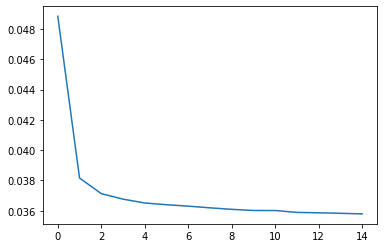

In [73]:
plt.plot( range(NUM_EPOCHS), epoch_loss)

In [74]:
noise_factor = 0.5
x_test_noisy = X_test.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape).astype(np.float32)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

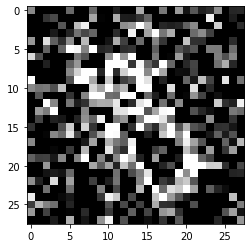

In [75]:
plt.imshow( x_test_noisy[2].reshape( 28, 28), cmap="gray") 


In [76]:
ret = denoiser( torch.from_numpy( x_test_noisy[2] )) 

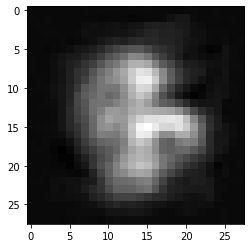

In [77]:
plt.imshow( ret.detach().numpy().reshape( 28, 28), cmap="gray") 